## Aims

1. Timescales may be directly estimated from signals using the first singular value or eigenvalue.
2. Multiple oscillations may be decomposed from aperiodic activity in the time domain via low rank SVD. This allows direct estimation of timescales.

## Autoregressive Models

Autoregressive coeffcients are solved as $\mathbf{X}w=y$, where $\mathbf{X}$ is a $n \times p$ Hankel matrix of lagged time series values, $w$ is the vector of autoregressive coefficients, and $y$ is a vector of future values along the signal. 

$$
\mathbf{X} =
    \left[ {\begin{array}{ccccc}
    x_{0} & x_{1} & x_{2} & \cdots & x_{p}\\
    x_{1} & x_{2} & x_{3} & \cdots & x_{p+1}\\
    x_{2} & x_{3} & x_{4} & \cdots & x_{p+2}\\
    \vdots & \vdots & \vdots & \ddots & \vdots\\
    x_{n-p-1} & x_{n-p} & x_{n-p+1} & \cdots & x_{n-1}\\
    \end{array} } \right] \\
\mathbf{y}^{\top} = 
    \left[ {\begin{array}{c}
    x_{p+1} \\
    x_{p+2} \\
    x_{p+3} \\ 
    \cdots \\
    x_{n} \\ 
    \end{array} } \right] \\
$$

## SVD

SVD can be used to solve AR weights, $w$, using the pseudo inverse (e.g. inverse of singular values).

$$
\begin{align*}
\mathbf{X}w &= y \\
w &= \mathbf{X}^{-1}y \\
\end{align*}
$$

SVD gives:

$$
\begin{align*}
\mathbf{X} &= USV^{\top} \\
\mathbf{X}^{-1} &= VS^{-1}U^{\top}\\
w &= VS^{-1}U^{\top}y
\end{align*}
$$

This is used for solving any AR(p) processes. But timescales are often captured by AR(1), even in the presence of other structure e.g. oscillations.

## Timescales and AR(1) 

Timescales refer to the decay rate of the autocorrelation function or the half width half max of power spectral density. Timescales may be directly quantified from the single AR(1) coefficient. Even in the presents of other temporal structure, the bias of an AR(1) approximation of the timescales slightly increases, while the computation time drastically decreases. 

$$
\begin{align*}
x^{\top} w &= y \\
\left[ {\begin{array}{ccccc}
x_{0} \\
x_{1} \\
x_{2} \\
\vdots \\
x_{n-1} \\
\end{array} } \right] w &= 
\left[ {\begin{array}{c}
x_{1} \\
x_{2} \\
x_{3} \\ 
\cdots \\
x_{n}\\ 
\end{array} } \right]^{\top} \\
\end{align*}
$$

For AR(1) only the first singular value is needed, thus $V = 1$ and $U=\frac{1}{\sigma_{1}}x$. Given this, $w$ may directly computed given the that the 2-norm of $x$ is $\sigma_1$ and the square of this 2-norm is $\lambda_1$. These norms fast to compute and are:

$$
\begin{align*}
||x||_2 = \sigma_1 \\
||x||_{2}^{2} = \lambda_1
\end{align*}
$$

These norms may be then used to directly compute the coefficient of an AR(1) process.

$$
\begin{align*}
w &= \frac{1}{\sigma_1} \frac{1}{\sigma_1} x y \\
&= \frac{1}{\lambda_1} x y
\end{align*}
$$

Once the AR(1) coefficient is computed, the timescale may be computed as either the decay rate of the autocorrelation function or the half width half max of power spectral density. Below, the decay rate of the ACF, $\tau$ is solved and converted to the knee frequency of log-log PSD $f_k$. $f_s$ is the sampling rate of the signal.

$$
\begin{align*}
w &= e^\frac{1}{\tau f_s} \\
\ln{(w)} &= \ln{(e^\frac{1}{\tau f_s})} = \frac{1}{\tau f_s} \\
\tau * f_s &= -\frac{1}{\ln{(w)}} \\
\tau &= -\frac{1}{\ln{(w)} \cdot f_s}
\end{align*}
$$

The knee frequency is given by:

$$
\begin{align*}
f_k &= \frac{1}{2 \pi \tau} \\
&= -\frac{\ln{(w)} \cdot f_s}{2 \pi} \\
\end{align*}
$$

### Decomposing Oscillations

For the above to work, oscillations must be removed from the signal if present, otherwise the first singular value will contain a mixture of aperiodic and periodic processes proportional to their relative amplitude. One way to remove oscillations is using a low-rank approximation of a high order $\mathbf{X}$. If not oscillations are present, the timescale may be compute as above, otherwise, oscillations should first be removed from the signal. The one caveat is that the signal must be stationary and the oscillation can't be bursty.

In [1]:
# Show in a simulation
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.regression.linear_model import burg

from neurodsp.sim import sim_oscillation, sim_bursty_oscillation
from neurodsp.spectral import compute_spectrum

from timescales.autoreg import ar_to_psd
from timescales.sim import sim_branching

import torch

In [19]:
n_seconds = 20

tau = 0.015
fk = 1/(2*np.pi*tau)

fs = 1000
#sig_pe_true = sim_oscillation(n_seconds, fs, 10, cycle='asine', rdsym=0.5)
sig_pe_true = sim_oscillation(n_seconds, fs, 10) + sim_oscillation(n_seconds, fs, 20) + sim_oscillation(n_seconds, fs, 60) / 2
# sig_pe_true = sim_bursty_oscillation(n_seconds, fs, 10) * 2
sig_ap_true = sim_branching(n_seconds, fs, tau, 1000, mean=0, variance=1)

sig = sig_ap_true + sig_pe_true
#sig = (sig-sig.mean())/sig.std()

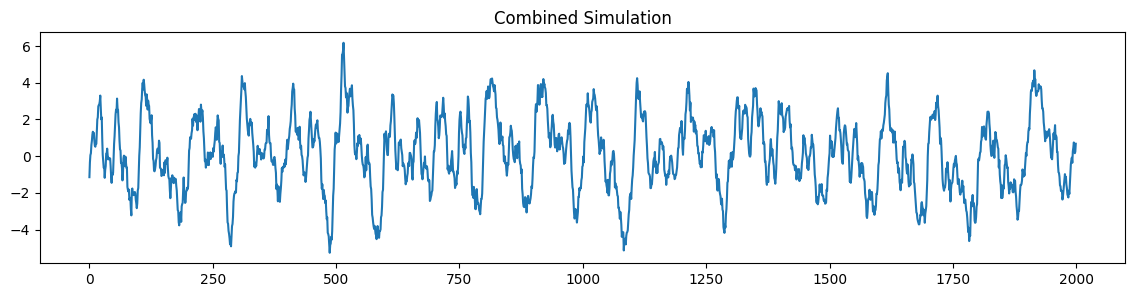

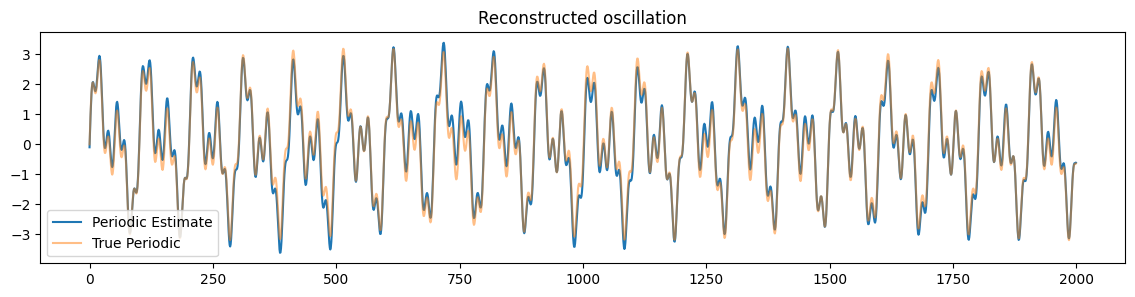

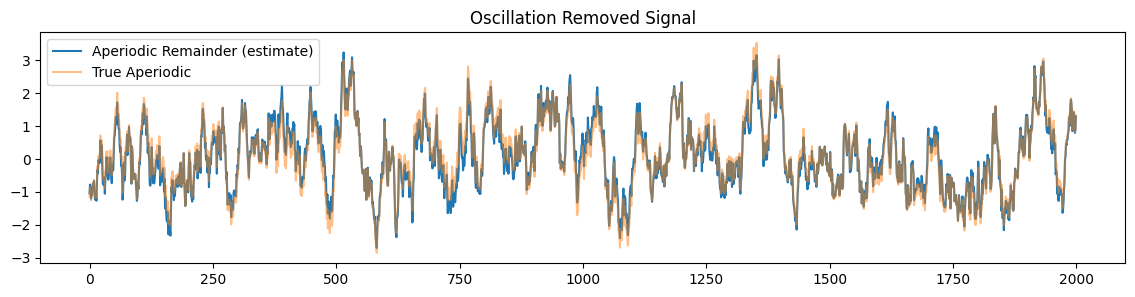

In [20]:
# Remove oscillations from time domain
p = 5000

X = np.lib.stride_tricks.as_strided(sig,
    shape=(len(sig)-p+1, p),
    strides=((sig.itemsize, sig.itemsize))
)[:-1]


y = sig[p:]

X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float()

U, S, V = torch.svd_lowrank(X_tensor, 10, 10)
S_diag = torch.diag(S)
S_diag_inv = torch.diag(1/S)

sig_pe = (V @ S_diag @ U.T)[0].numpy()
sig_ap = sig[:-p] - sig_pe 


# Plot
plt.figure(figsize=(14, 3))
plt.plot(sig[:2000])
plt.title('Combined Simulation')

plt.figure(figsize=(14, 3))
plt.plot(sig_pe[:2000], label='Periodic Estimate')
plt.plot(sig_pe_true[:2000], alpha=.5, label='True Periodic')
plt.title('Reconstructed oscillation')
plt.legend();

plt.figure(figsize=(14, 3))
plt.title('Oscillation Removed Signal')
plt.plot(sig_ap[:2000], label='Aperiodic Remainder (estimate)')
plt.plot(sig_ap_true[:2000], alpha=.5, label='True Aperiodic')
plt.legend();

In [21]:
%%timeit
e1_inv = 1/(np.linalg.norm(sig[:-1])**2)
w = float(e1_inv * sig[:-1] @ sig[1:])

24.1 µs ± 325 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [22]:
# Compute AR(1) coefficient)
e1_inv = 1/(np.linalg.norm(sig_ap)**2)
w = float(e1_inv * sig_ap[:-1] @ sig_ap[1:])
print("AR(1) = ", w)

AR(1) =  0.9340688160275534


In [23]:
fs = 1000

# Convert AR(1) coefficient to knee and tau
fk_est = -(np.log(w) * fs) / (2 * np.pi)
tau_est = -(1/(np.log(w) * fs))

# Results
print("Estimated: ", 'tau=', tau_est, 'fk=', fk_est)
print("True     : ", 'tau=', tau, 'fk=', fk)

Estimated:  tau= 0.014661646303778763 fk= 10.855189096389275
True     :  tau= 0.015 fk= 10.61032953945969


fk_welch =  4.85819404898852


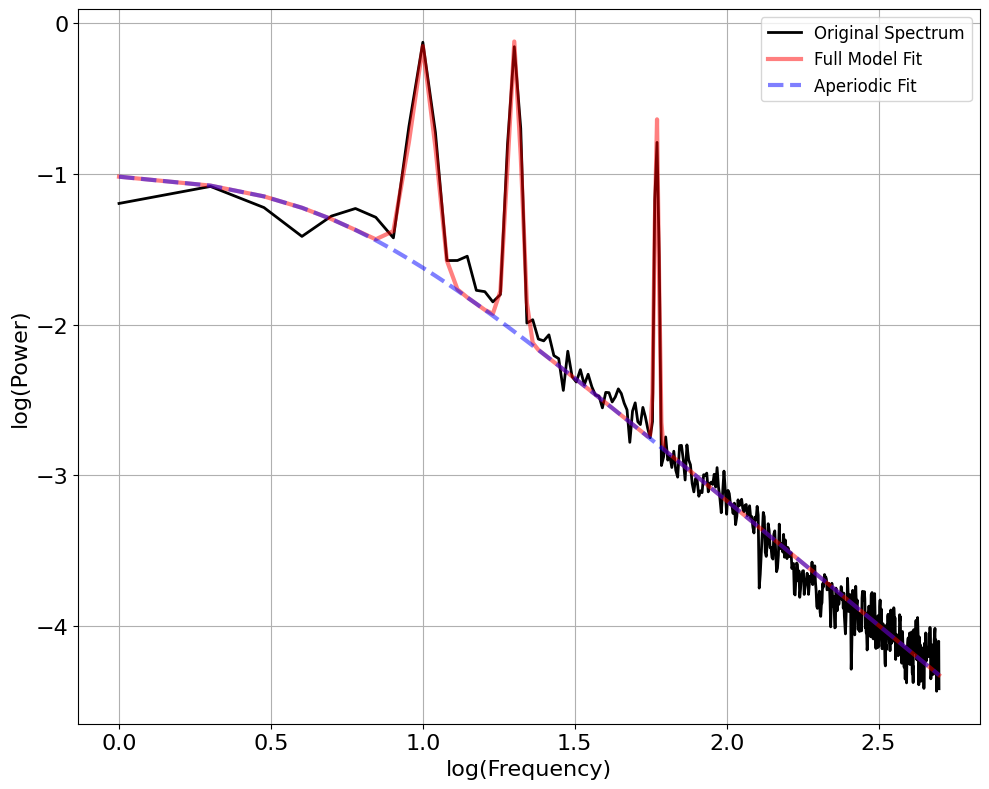

In [24]:
from fooof import FOOOF

freqs, powers = compute_spectrum(sig, fs)
freqs, powers = freqs[1:], powers[1:]

fm = FOOOF(aperiodic_mode='knee', max_n_peaks=3, verbose=False)
fm.fit(freqs, powers)
fm.plot(plt_log=True)

fk_welch = fm.aperiodic_params_[1]
print('fk_welch = ', fk_welch)

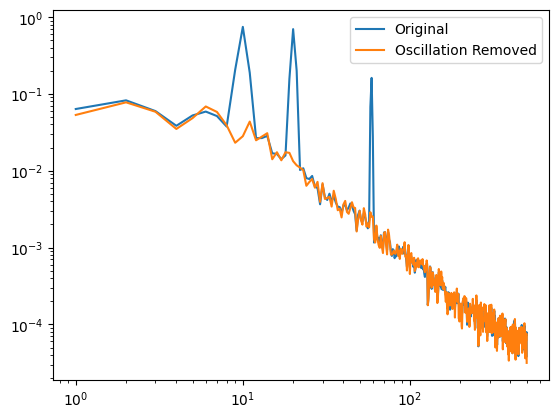

In [25]:
from fooof import FOOOF


freqs, powers = compute_spectrum(sig, fs)
freqs, powers = freqs[1:], powers[1:]
plt.loglog(freqs, powers, label='Original')

freqs, powers = compute_spectrum(sig_ap, fs)
freqs, powers = freqs[1:], powers[1:]
plt.loglog(freqs, powers, label='Oscillation Removed')
plt.legend();

fk_welch =  5.393764083329426


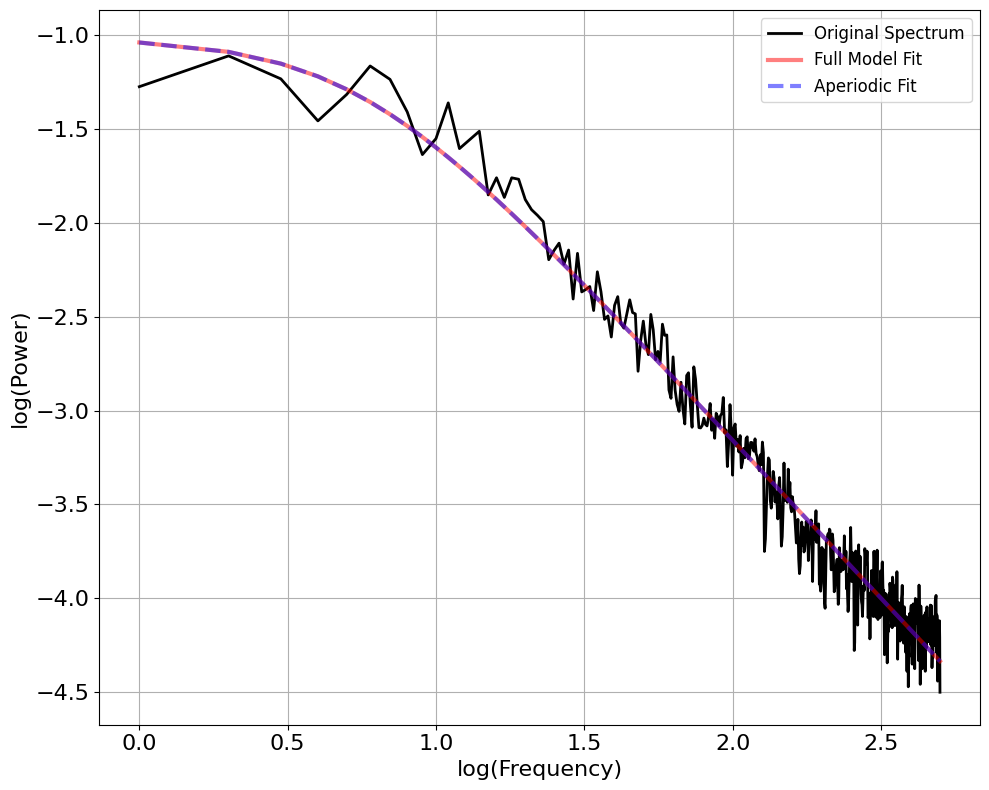

In [26]:
fm = FOOOF(aperiodic_mode='knee', max_n_peaks=0, verbose=False)
fm.fit(freqs, powers)
fm.plot(plt_log=True)

fk_welch = fm.aperiodic_params_[1]
print('fk_welch = ', fk_welch)